In [56]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools as axtools

import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'hipstr_discovery'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

In [57]:
from djPyi2 import pandas_methods as pm

In [110]:
reload(DJ)

<module 'djPyi2' from '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/djPyi2/djPyi2/__init__.pyc'>

# dowload str reference sites:
we will put them in here 
    `mkdir /frazer01/home/djakubosky/software/HipSTR/references'
    
    cd /frazer01/home/djakubosky/software/HipSTR/
    
    wget https://github.com/HipSTR-Tool/HipSTR-references/raw/master/human/GRCh37.hipstr_reference.bed.gz
    
    mkdir split_ref

In [179]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl'
sample_info = pd.read_pickle(fn)

# Split the reference into 1k different bedfiles for parallel processing

In [62]:
def split_seq(seq, num_pieces):
    start = 0
    for i in xrange(num_pieces):
        stop = start + len(seq[i::num_pieces])
        yield seq[start:stop]
        start = stop

In [67]:
fn_ref = '/frazer01/home/djakubosky/software/HipSTR/references/GRCh37.hipstr_reference.bed.gz'

In [70]:
len_ref = ! zcat {fn_ref} | wc -l 
len_ref = int(len_ref[0].split()[0])

In [74]:
out_folder = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref'
out_folder = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref_200'

In [81]:
DJ.makedir(out_folder)

In [84]:
regions_list = '/frazer01/projects/hipsci/pipeline/WGS/HipSTR/reference_200.list'
R = open(regions_list, 'w')
with gzip.open(fn_ref, 'rU') as F:
    count = 1
    line_counter = 0
    file_name =  out_folder + '/ref_{}.bed'.format(count)
    R.write(file_name + '\n')
    fout = open(file_name, 'w')
    for line in F:
        line = line.rstrip()
        if line_counter == 200:
            fout.close()
            count += 1
            file_name =  out_folder + '/ref_{}.bed'.format(count)
            R.write(file_name + '\n')
            fout = open(file_name, 'w')
            line_counter = 0
            
        fout.write(line + '\n')
        line_counter +=1
R.close()

In [68]:
bam_files = '/frazer01/projects/hipsci/pipeline/WGS/GenomeSTRiP/bam_list.list'

In [45]:
bam_list = private_out + '/bam_list.txt'
! cp {bam_files} {bam_list}

In [82]:
trunc_test_bed = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/trunc_ref.bed'

In [62]:
# subset of the hipsci files
trunc_hip_files = private_out + '/bam_files_hipsci_trunc.txt'
! head -n152 {bam_files} > {trunc_hip_files}

In [156]:
reference = '/frazer01/publicdata/gatk_bundle_2.8/b37/human_g1k_v37_decoy_Sendai.fasta'
hipstr = '/frazer01/home/djakubosky/software/HipSTR/HipSTR'
regions_test = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed'
vcf_out = private_out + '/ipscore_reg_1.vcf.gz'
test_script = private_out + '/test_ipscore_reg1.sh'
bam_files_ipscore = '/frazer01/projects/hipsci/pipeline/WGS/bam_cardips.txt'
stutter_model = 'stutter_model_ipscore.txt'

command = '{} --bam-files {} --fasta {} --regions {} --str-vcf {} --stutter-out {}'.format(hipstr, bam_files_ipscore, reference, regions_test, vcf_out, stutter_model)

with open(test_script, 'w') as F:
    F.write(command + '\n')
    

In [157]:
reference = '/frazer01/publicdata/hs37d5/hs37d5.fa'
bam_files = '/frazer01/projects/hipsci/pipeline/WGS/bam_hipsci.txt'
hipstr = '/frazer01/home/djakubosky/software/HipSTR/HipSTR'
regions_test = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed'
vcf_out = private_out + '/hipsci_reg_1.vcf.gz'
test_script = private_out + '/test_hipsci_reg1.sh'
stutter_model = 'stutter_model_hipsci.txt'
command = '{} --bam-files {} --fasta {} --regions {} --str-vcf {} --stutter-out {}'.format(hipstr, trunc_hip_files, reference, regions_test, vcf_out, stutter_model)

with open(test_script, 'w') as F:
    F.write(command + '\n')

# Tabix index all the vcfs 

In [92]:
fn = '/frazer01/projects/hipsci/pipeline/WGS/HipSTR/tabix_hipsci.sh'
vcfs = glob.glob('/frazer01/projects/hipsci/pipeline/WGS/HipSTR/output_hipsci_200/*.vcf.gz')
with open(fn, 'w') as F:
    command = 'module add tabix'
    F.write(command + '\n')
    for v in vcfs:
        command = 'tabix -f -p vcf {}'.format(v)
        F.write(command + '\n')
    

# split the ipscore bams into two subsets, compare those

In [196]:
def write_command(bam_files, ref, regions, vcf_out, stutter_out, fn_script, 
                  hipstr= '/frazer01/home/djakubosky/software/HipSTR/HipSTR'):
    
    
    command = '{} --bam-files {} --fasta {} --regions {} --str-vcf {} --stutter-out {}'.format(hipstr, bam_files,
                                                                                               ref, regions, 
                                                                                               vcf_out, stutter_out)

    with open(fn_script, 'w') as F:
        F.write(command + '\n')
        
    print command
    print 'script: {}'.format(fn_script)

In [180]:
t = sample_info[sample_info.STUDY == 'iPSCORE']

In [181]:
# shuffle samples- would be better if we had most unrelated samples in each batch, 
# not sure if order has any structure to begin with
t = t.sample(frac=1)

In [184]:
bam_ipscore_1 = t.head(125)
bam_ipscore_2 = t.tail(125)

In [191]:
fn_ipscore1 = private_out + '/bams_ipscore_1.txt'
bam_ipscore_1['bamfile'].to_csv(fn_ipscore1, sep = '\t', header = False, index = False)

In [192]:
fn_ipscore2 = private_out + '/bams_ipscore_2.txt'
bam_ipscore_2['bamfile'].to_csv(fn_ipscore2, sep = '\t', header = False, index = False)

In [199]:
reference = '/frazer01/publicdata/hs37d5/hs37d5.fa'
hipstr = '/frazer01/home/djakubosky/software/HipSTR/HipSTR'
regions_test = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed'
vcf_out = private_out + '/ipscore1_reg_1.vcf.gz'
test_script = private_out + '/test_ipscore1_reg1.sh'
stutter_model = 'stutter_model_ipscore1.txt'

write_command(fn_ipscore1, reference, regions_test, vcf_out, stutter_model, test_script)

/frazer01/home/djakubosky/software/HipSTR/HipSTR --bam-files /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/bams_ipscore_1.txt --fasta /frazer01/publicdata/hs37d5/hs37d5.fa --regions /frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed --str-vcf /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/ipscore1_reg_1.vcf.gz --stutter-out stutter_model_ipscore1.txt
script: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/test_ipscore1_reg1.sh


In [286]:
reference = '/frazer01/publicdata/hs37d5/hs37d5.fa'
hipstr = '/frazer01/home/djakubosky/software/HipSTR/HipSTR'
regions_test = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_4.bed'
vcf_out = private_out + '/ipscore1_reg_4.vcf.gz'
test_script = private_out + '/test_ipscore_reg4.sh'
stutter_model = 'stutter_model_ipscore1.txt'

write_command(bam_files_ipscore, reference, regions_test, vcf_out, stutter_model, test_script)

/frazer01/home/djakubosky/software/HipSTR/HipSTR --bam-files /frazer01/projects/hipsci/pipeline/WGS/bam_cardips.txt --fasta /frazer01/publicdata/hs37d5/hs37d5.fa --regions /frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_4.bed --str-vcf /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/ipscore1_reg_4.vcf.gz --stutter-out stutter_model_ipscore1.txt
script: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/test_ipscore_reg4.sh


In [200]:
reference = '/frazer01/publicdata/hs37d5/hs37d5.fa'
hipstr = '/frazer01/home/djakubosky/software/HipSTR/HipSTR'
regions_test = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed'
vcf_out = private_out + '/ipscore2_reg_1.vcf.gz'
test_script = private_out + '/test_ipscore2_reg1.sh'
stutter_model = 'stutter_model_ipscore2.txt'

write_command(fn_ipscore2, reference, regions_test, vcf_out, stutter_model, test_script)

/frazer01/home/djakubosky/software/HipSTR/HipSTR --bam-files /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/bams_ipscore_2.txt --fasta /frazer01/publicdata/hs37d5/hs37d5.fa --regions /frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed --str-vcf /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/ipscore2_reg_1.vcf.gz --stutter-out stutter_model_ipscore2.txt
script: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/test_ipscore2_reg1.sh


In [285]:
trunc_hip_files = private_out + '/bam_files_hipsci_trunc.txt'

reference = '/frazer01/publicdata/hs37d5/hs37d5.fa'
hipstr = '/frazer01/home/djakubosky/software/HipSTR/HipSTR'
regions_test = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_4.bed'
vcf_out = private_out + '/hipsci_reg_4.vcf.gz'
test_script = private_out + '/test_hipsci_reg4.sh'
stutter_model = 'stutter_model_hipsci_reg4.txt'

write_command(trunc_hip_files, reference, regions_test, vcf_out, stutter_model, test_script)

/frazer01/home/djakubosky/software/HipSTR/HipSTR --bam-files /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/bam_files_hipsci_trunc.txt --fasta /frazer01/publicdata/hs37d5/hs37d5.fa --regions /frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_4.bed --str-vcf /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/hipsci_reg_4.vcf.gz --stutter-out stutter_model_hipsci_reg4.txt
script: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/test_hipsci_reg4.sh


In [69]:
reference = '/frazer01/publicdata/hs37d5/hs37d5.fa'

bam_files = private_out + '/bam_list.txt'

hipstr = '/frazer01/home/djakubosky/software/HipSTR/HipSTR'

regions_test = '/frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed'


vcf_out = private_out + '/reg_1_all.vcf.gz'

test_script = private_out + '/test_all_reg1.sh'

In [1]:
command = '{} --bam-files {} --fasta {} --regions {} --str-vcf {} --stutter-out'.format(hipstr, bam_files, reference, regions_test, vcf_out)
with open(test_script, 'w') as F:
    F.write(command + '\n')

/frazer01/home/djakubosky/software/anaconda/bin:/frazer01/home/djakubosky/software/svtoolkit/bwa/:/frazer01/software/htslib-1.2.1/bin:/frazer01/software/sambamba_v0.5.9:/frazer01/software/samtools-1.2:/frazer01/home/djakubosky/software/vawk/:/frazer01/home/djakubosky/bin:/frazer01/home/djakubosky/software/bin/:/frazer01/software/vcflib-20151228/bin:/frazer01/home/djakubosky/software/libbeato/beato:/frazer01/home/djakubosky/software/circos-0.69-2/bin:/frazer01/software/R-3.3.0/bin:/software/bedtools-2.25.0/genomes:/frazer01/software/bedtools-2.25.0/bin:/opt/sge/bin:/opt/sge/bin/lx-amd64:/bin:/usr/bin:/usr/local/sbin:/usr/sbin

In [73]:
print command

/frazer01/home/djakubosky/software/HipSTR/HipSTR --bam-files /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/bam_list.txt --fasta /frazer01/publicdata/hs37d5/hs37d5.fa --regions /frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed --str-vcf /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/reg_1_all.vcf.gz


In [ ]:
/frazer01/home/djakubosky/software/HipSTR/HipSTR --bam-files /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/bam_list.txt --fasta /frazer01/publicdata/hs37d5/hs37d5.fa --regions /frazer01/home/djakubosky/software/HipSTR/references/split_ref/ref_1.bed --str-vcf /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/reg_1_all2.vcf.gz

# Comparing stutter models between iPSCORE and HipSci 

INFRAME_PGEOM	Parameter for in-frame geometric step size distribution
INFRAME_UP	Probability that stutter causes an in-frame increase in obs. STR size
INFRAME_DOWN	Probability that stutter causes an in-frame decrease in obs. STR size
OUTFRAME_PGEOM	Parameter for out-of-frame geometric step size distribution
OUTFRAME_UP	Probability that stutter causes an out-of-frame increase in obs. STR size
OUTFRAME_DOWN

In [116]:
def prep(df):
    df = df.copy()
    df.pipe(pm.concat_cols,  ['CHROM', 'START', 'END'], name = 'ID', inplace = True)
    df.index = df.ID
    return df

In [102]:
cols = 'CHROM	START	END	IGEOM	IDOWN	IUP	OGEOM	ODOWN	OUP PERIOD'.split()

In [229]:
fn1 = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/stutter_model_hipsci.txt'
stutter_hip = pd.read_table(fn1, names=cols).pipe(prep)

fn1 = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/stutter_model_ipscore.txt'
stutter_ip = pd.read_table(fn1, names=cols).pipe(prep)

print stutter_ip.shape
print stutter_hip.shape

j = stutter_ip.join(stutter_hip, rsuffix= '_H', lsuffix= '_I', how='inner')
print j.shape

In [243]:
fn1 = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/stutter_model_ipscore1.txt'
stutter_ip1 = pd.read_table(fn1, names=cols).pipe(prep)

fn1 = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_discovery/stutter_model_ipscore2.txt'
stutter_ip2 = pd.read_table(fn1, names=cols).pipe(prep)

print stutter_ip1.shape
print stutter_ip2.shape
k = stutter_ip1.join(stutter_ip2, rsuffix= '_1', lsuffix= '_2', how='inner')
print k.shape

(1730, 11)
(1728, 11)
(1728, 22)


In [279]:
def plot_params(df, suff1 = '_H', suff2='_I', xlab= 'HipSci', ylab= 'iPSCORE'):
    params_to_plot = 'IGEOM	IDOWN	IUP	OGEOM	ODOWN	OUP PERIOD'.split()
    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(3, 2, figsize = (8, 10))
        ax = fig.get_axes()
        
        for i in range(6):
            axes = ax[i]
            param = params_to_plot[i]
            p1 = param + suff1
            p2 = param + suff2

            axes.scatter(df[p1].astype(float), df[p2].astype(float))
            axes.set(xlabel = '{} {}'.format(xlab, param), ylabel = '{} {}'.format(ylab, param))
            axes.set_title(param)
            axes.axis('scaled')
    #         axes.set_aspect('equal', 'box')
            x0,x1 = axes.get_xlim()
            y0,y1 = axes.get_ylim()
    #         print  x0,x1, y0,y1, param


            max_dim = max(x1, y1)

            axes.set_xlim(-0.01, max_dim)
            axes.set_ylim(-0.01, max_dim)

    #         axes.set_xticks(ticks)


            x0,x1 = axes.get_xlim()
            y0,y1 = axes.get_ylim()

    #         print  x0,x1, y0,y1, param

            axes.set_aspect((x1-x0)/(y1-y0))

            loc = ticker.MaxNLocator(nbins = 6)
            axes.yaxis.set_major_locator(loc)
            axes.xaxis.set_major_locator(loc)

    #         print ticks, param
 
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig, ax


1729 sites in common 

Text(0.5,0.98,u'All Sizes- iPSCORE-HipSci')

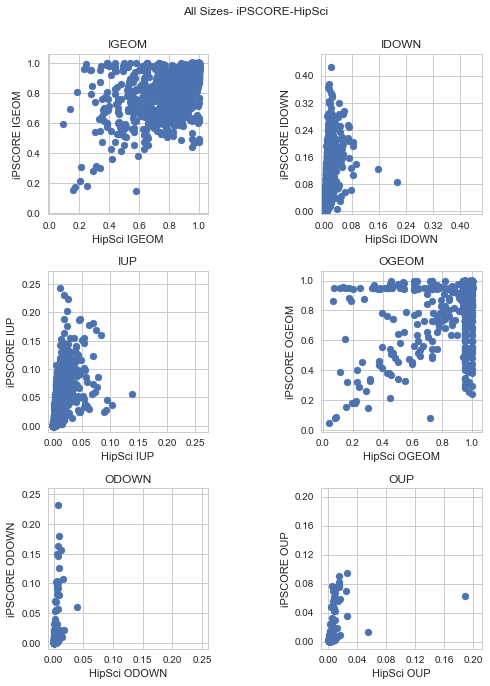

In [277]:
fig, ax = plot_params(j)
plt.suptitle('All Sizes- iPSCORE-HipSci')

Text(0.5,0.98,u'All Sizes- iPSCORE-HipSci- Repeat size 1')

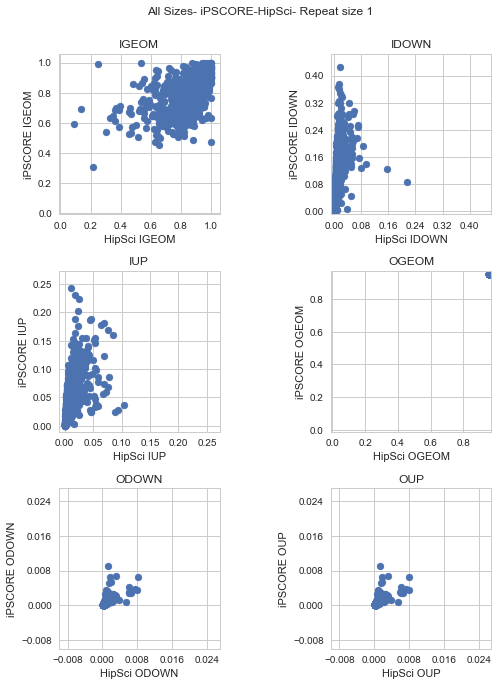

In [280]:
fig, ax = plot_params(j[j.PERIOD_H == 1])
plt.suptitle('All Sizes- iPSCORE-HipSci- Repeat size 1')

Text(0.5,0.98,u'All Sizes- iPSCORE-HipSci- Repeat size 2')

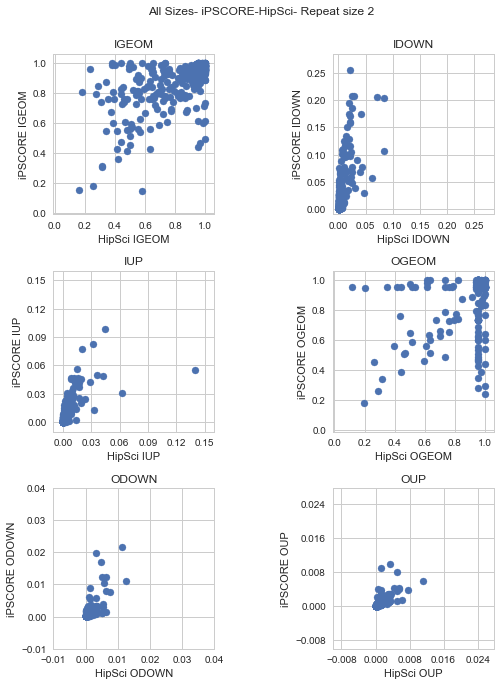

In [281]:
fig, ax = plot_params(j[j.PERIOD_H == 2])
plt.suptitle('All Sizes- iPSCORE-HipSci- Repeat size 2')

Text(0.5,0.98,u'All Sizes- iPSCORE-HipSci- Repeat size 3')

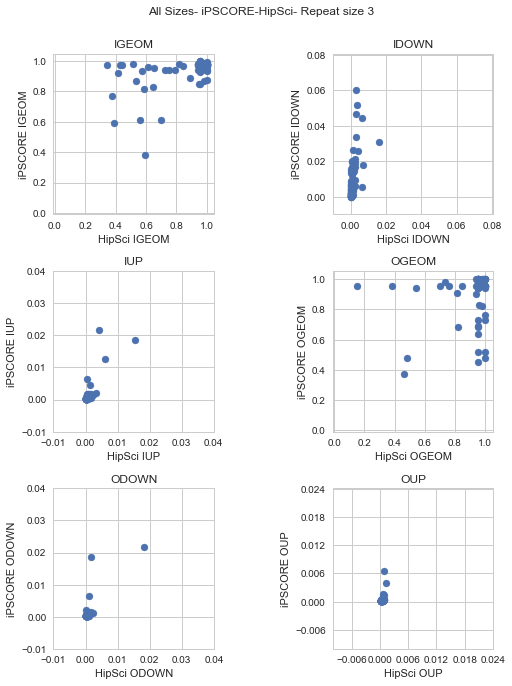

In [284]:
fig, ax = plot_params(j[j.PERIOD_H == 3])
plt.suptitle('All Sizes- iPSCORE-HipSci- Repeat size 3')

Text(0.5,0.98,u'All Sizes- iPSCORE-HipSci- Repeat size >=4')

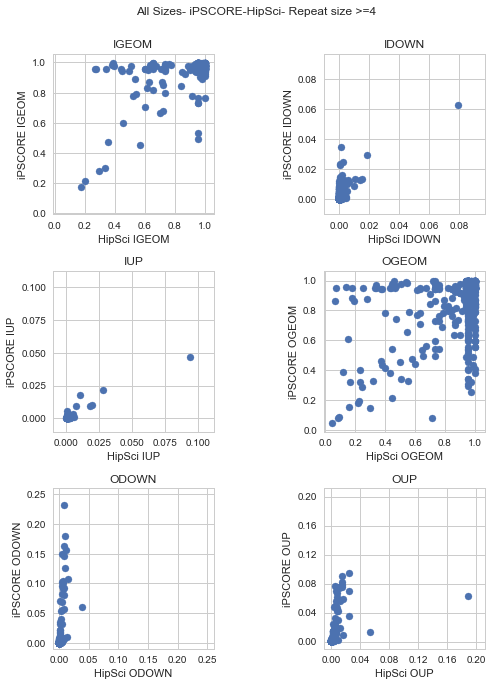

In [283]:
fig, ax = plot_params(j[j.PERIOD_H >= 4])
plt.suptitle('All Sizes- iPSCORE-HipSci- Repeat size >=4')

Text(0.5,0.98,u'All Sizes- iPSCORE-iPSCORE')

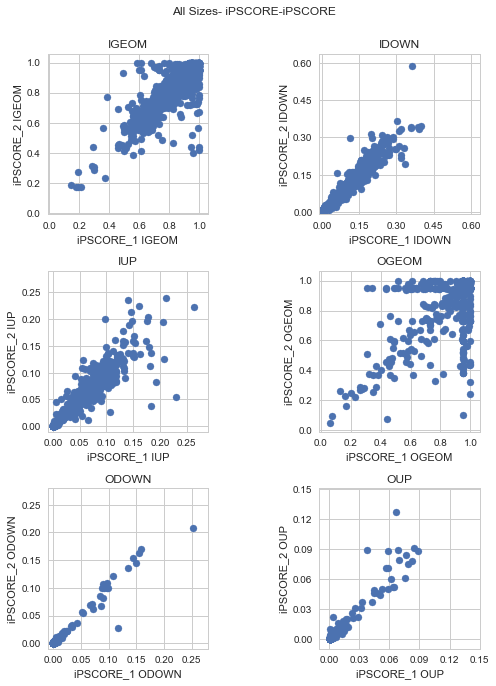

In [278]:
fig, ax = plot_params(k, suff1='_1', suff2='_2', xlab='iPSCORE_1', ylab='iPSCORE_2')
plt.suptitle('All Sizes- iPSCORE-iPSCORE')

In [236]:
params_to_plot = 'IGEOM	IDOWN	IUP	OGEOM	ODOWN	OUP PERIOD'.split()

In [220]:
import matplotlib.ticker as ticker

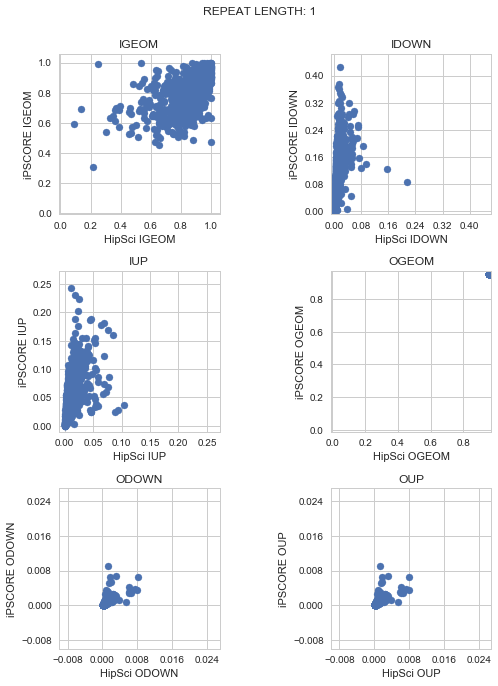

In [263]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(3, 2, figsize = (8, 10))
    ax = fig.get_axes()
    for i in range(6):
        axes = ax[i]
        param = params_to_plot[i]
        p1 = param + '_H'
        p2 = param + '_I'
        
        axes.scatter(j[j.PERIOD_I ==1][p1].astype(float), j[j.PERIOD_I ==1][p2].astype(float))
        axes.set(xlabel = 'HipSci {}'.format(param), ylabel = 'iPSCORE {}'.format(param))
        axes.set_title(param)
        axes.axis('scaled')
#         axes.set_aspect('equal', 'box')
        x0,x1 = axes.get_xlim()
        y0,y1 = axes.get_ylim()
#         print  x0,x1, y0,y1, param
        
        
        max_dim = max(x1, y1)
        
        axes.set_xlim(-0.01, max_dim)
        axes.set_ylim(-0.01, max_dim)
        
#         axes.set_xticks(ticks)
        
        
        x0,x1 = axes.get_xlim()
        y0,y1 = axes.get_ylim()
        
#         print  x0,x1, y0,y1, param
        
        axes.set_aspect((x1-x0)/(y1-y0))
        
        loc = ticker.MaxNLocator(nbins = 6)
        axes.yaxis.set_major_locator(loc)
        axes.xaxis.set_major_locator(loc)
        
#         print ticks, param
    plt.suptitle('REPEAT LENGTH: 1')   
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

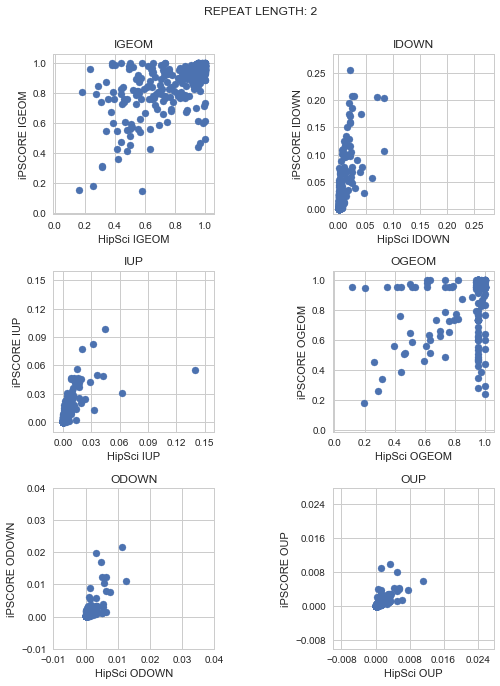

In [265]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(3, 2, figsize = (8, 10))
    ax = fig.get_axes()
    for i in range(6):
        axes = ax[i]
        param = params_to_plot[i]
        p1 = param + '_H'
        p2 = param + '_I'
        
        axes.scatter(j[j.PERIOD_I == 2][p1].astype(float), j[j.PERIOD_I ==2][p2].astype(float))
        axes.set(xlabel = 'HipSci {}'.format(param), ylabel = 'iPSCORE {}'.format(param))
        axes.set_title(param)
        axes.axis('scaled')
#         axes.set_aspect('equal', 'box')
        x0,x1 = axes.get_xlim()
        y0,y1 = axes.get_ylim()
#         print  x0,x1, y0,y1, param
        
        
        max_dim = max(x1, y1)
        
        axes.set_xlim(-0.01, max_dim)
        axes.set_ylim(-0.01, max_dim)
        
#         axes.set_xticks(ticks)
        
        
        x0,x1 = axes.get_xlim()
        y0,y1 = axes.get_ylim()
        
#         print  x0,x1, y0,y1, param
        
        axes.set_aspect((x1-x0)/(y1-y0))
        
        loc = ticker.MaxNLocator(nbins = 6)
        axes.yaxis.set_major_locator(loc)
        axes.xaxis.set_major_locator(loc)
        
#         print ticks, param
        
    plt.suptitle('REPEAT LENGTH: 2')   
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [252]:
j.PERIOD_H.value_counts()

1    838
2    355
4    215
5    126
6    114
3     81
Name: PERIOD_H, dtype: int64

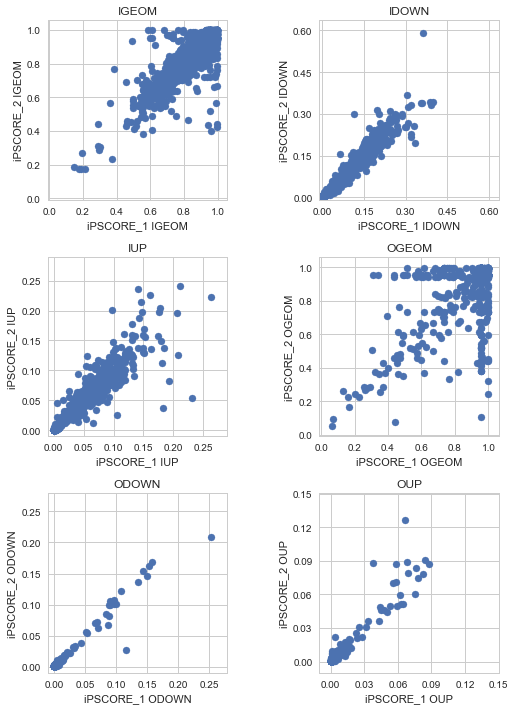

In [246]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(3, 2, figsize = (8, 10))
    ax = fig.get_axes()
    for i in range(6):
        axes = ax[i]
        param = params_to_plot[i]
        p1 = param + '_1'
        p2 = param + '_2'
        
        axes.scatter(k[p1].astype(float), k[p2].astype(float))
        axes.set(xlabel = 'iPSCORE_1 {}'.format(param), ylabel = 'iPSCORE_2 {}'.format(param))
        axes.set_title(param)
        axes.axis('scaled')
#         axes.set_aspect('equal', 'box')
        x0,x1 = axes.get_xlim()
        y0,y1 = axes.get_ylim()
#         print  x0,x1, y0,y1, param
        
        
        max_dim = max(x1, y1)
        
        axes.set_xlim(-0.01, max_dim)
        axes.set_ylim(-0.01, max_dim)
        
#         axes.set_xticks(ticks)
        
        
        x0,x1 = axes.get_xlim()
        y0,y1 = axes.get_ylim()
        
#         print  x0,x1, y0,y1, param
        
        axes.set_aspect((x1-x0)/(y1-y0))
        
        loc = ticker.MaxNLocator(nbins = 6)
        axes.yaxis.set_major_locator(loc)
        axes.xaxis.set_major_locator(loc)
        
#         print ticks, param
        
    plt.tight_layout()